## FACET2e BMAD simple example

You will need to install pytao, BMAD, and openpmd-beamphysics (as well as standard libraries like numpy, matplotlib and pandas)

 conda install -c conda-forge bmad
 conda install -c conda-forge pytao, openpmd-beamphysics

In [1]:
from pytao import Tao
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import re
import io
from os import path,environ
import pandas as pd
import random

from pmd_beamphysics import ParticleGroup
from pmd_beamphysics.statistics import resample_particles

from plotNMM import plotNMM, slicePlotNMM
from IPython.display import display

#needed for lattice_init
#%env FACET2_LATTICE /u/ar/dcesar/notebooks/facet_bmad
#%env FACET2_LATTICE /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample

import os
filePath = os.getcwd()
%env FACET2_LATTICE {filePath}

print('Make sure enviornment was set!:  ', environ['FACET2_LATTICE']) 

env: FACET2_LATTICE=/Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample
Make sure enviornment was set!:   /Users/nmajik/Documents/SLAC/slacsyncgit/bmadExample


# Start tao

In [2]:
tao=Tao('-init {:s}/bmad/models/f2_elec/tao_MFFF.init -noplot'.format(environ['FACET2_LATTICE'])) 
#tao=Tao('-init {:s}/bmad/models/f2_elec/tao.init'.format(environ['FACET2_LATTICE'])) 

## Plot single particle twiss

In [3]:
elements=tao.lat_ele_list();
#tao.lat_list(elements[0],'ElementType')
#tao.ele_gen_attribs(elements[0])

In [4]:
floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)
floorplan[::25].head(7)

,Index,ElementName,ElementType,s,ds,X,Y,Z,Theta,Phi,Psi
1,1,DL00,Drift,-0.86905,-0.86905,10.69357,0.0,1001.56206,-0.61087,0.0,0.0
26,26,DL01H,Drift,1.03220,0.09012,9.60305,0.0,1003.11948,-0.61087,0.0,0.0
51,51,L0BF#2,Lcavity,5.25643,0.33713,7.18014,0.0,1006.57976,-0.61087,0.0,0.0
76,76,QE10441,Quadrupole,8.50702,0.10800,5.31568,0.0,1009.24248,-0.61087,0.0,0.0
101,101,QE10511#1,Quadrupole,11.14513,0.05400,3.80475,0.0,1011.40031,-0.61087,0.0,0.0
126,126,BPM10581,Monitor,14.40167,0.00000,1.93688,0.0,1014.06791,-0.61087,0.0,0.0
151,151,QB10731#1,Quadrupole,17.73408,0.05340,0.26540,0.0,1016.91774,-0.30543,0.0,0.0


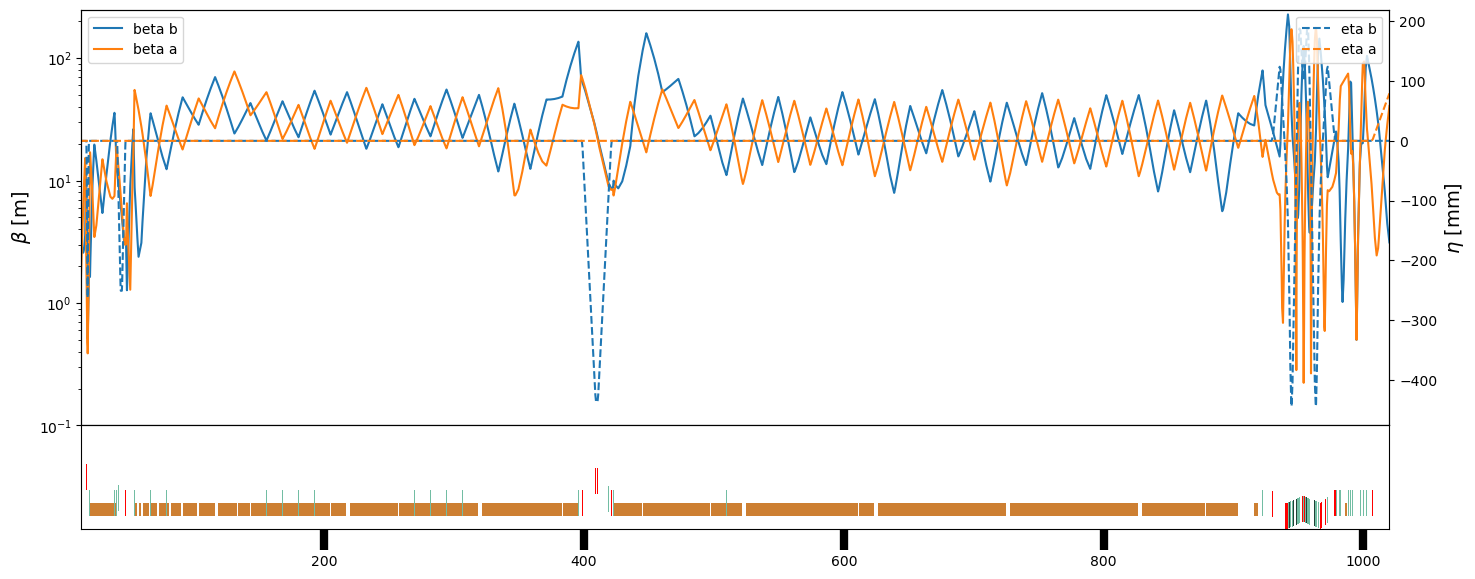

In [5]:
colorlist=['#982649', '#6BCAE2', '#72bda3', '#ed6a5a', '#533a71']
colorlist2=['#E2836A','#6a7ee2','#74e26a']

def floorplan_sorter(ele):
    """
    ele is an element of a pandas dictionary made from the bmad floorplan (made to look like an elegant floorplan from my "elegant_helpers" file). This sorter parses the columns to make a "patch" for plotting purposes. See floorplan_patches().
    """
    if ele['ds']==0:
        ele['ds']=0.05
    s0=float(ele['s'])-float(ele['ds'])
    x=float(ele['X'])*2-0.5
    
    if (re.search('DRIF',ele.ElementType.upper())!=None)|(ele.ElementType.upper()=='MARK'):
        patchColor=None
        patch=None
    elif (re.search('BEND',ele.ElementType.upper())!=None)|(re.search('KICK',ele.ElementType.upper())!=None):
        patchColor='r'
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif re.search('XL',ele.ElementName.upper())!=None:
        patchColor=colorlist2[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'QUAD' in ele.ElementType.upper():
        patchColor=colorlist[2]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'SEXT' in ele.ElementType.upper():
        patchColor="#204337"
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    elif 'RFCW' in ele.ElementType.upper() or 'CAV' in ele.ElementType.upper():
        string_lst=['L3_10_50','L3_10_25','L2_10_25','L2_10_50','X1_Xband','L1_10_25','L1_9_25','L1_9_50'] #nonzero voltage
        if re.findall(r"(?=("+'|'.join(string_lst)+r"))",ele.ElementName)!=None:
            patchColor="#CD7F32"
            patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=0.5,color=patchColor,lw=0,ls=None)
    elif re.search('^UM',ele.ElementName)!=None:
        patchColor=colorlist[1]
        patch=mpatches.Rectangle(xy=(s0,x),width=float(ele['ds']),height=1,color=patchColor,lw=0,ls=None)
    else:
        patchColor=None
        patch=None
        
    return patch

def floorplan_patches(floorplan,zbounds=None):
    """
    This function returns a list of patches to be plotted (patches) and a list of patches for the legend (leg_patches). If zbounds=[zmin,zmax] is given then the plot is restricted to the bounds. 
    
    Useage:
    
    fp=SDDS(0)
    fp.load(LCLS2scS.flr)
    __,floorplan=sdds2pd(fp)
    patches,leg_patches=flooplan_patches(floorplan,[3425,3750])
    """
    if zbounds==None:
        zbounds=[flooplan['s'].min(),flooplan['s'].max()]
    sFloor=floorplan.s.astype(dtype=float);
    sFloor=sFloor.values
    ii=0;
    patches=[];
    for index, ele in (floorplan.iloc[(sFloor>zbounds[0])&(sFloor<zbounds[1])]).iterrows():
        patches.append(floorplan_sorter(ele))
    
    quad_patch = mpatches.Patch(color=colorlist[2], label='Quad')
    sext_patch = mpatches.Patch(color="#204337", label='Linac')
    bend_patch = mpatches.Patch(color='red', label='Bend')
    leg_patches=[quad_patch,sext_patch,bend_patch];
    return patches,leg_patches
    
def floorplan_plot(ax_fp,floorplan,zmin=0,zmax=2000):  
    """
    This function plots "patches" for basic elements in the lattice. This can help identify what you're looking at in a "z-plot".
    """
    
    patches,leg_patches=floorplan_patches(floorplan,[zmin,zmax])

    for p in patches:
        if p!=None:
            ax_fp.add_patch(p)

    ax_fp.plot((zmin,zmax),(0,0),'k',alpha=0.0)
    ax_fp.tick_params(axis='x',direction='out',length=15,width=6,color='k',bottom=True)
    plt.yticks([])
    #ax_fp.set_ylim([-3,1])
    ax_fp.set_xlim([zmin,zmax])
    return ax_fp
    
def format_longitudinal_plot(fig):
    """
    This function helps format a "z-plot" by providing axes for the main plot and for the a floorplan_plot. It also plots the floorplan.
    """
    outer_grid=fig.add_gridspec(5,1,hspace=0)
    ax=fig.add_subplot(outer_grid[0:4,:])
    ax_fp=fig.add_subplot(outer_grid[4,:], sharex = ax)
    floorplan_plot(ax_fp,floorplan)
    plt.sca(ax)
    
    return ax, ax_fp 


#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,250])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=13
zmax=1020

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

# Beam construction

In [6]:
#Optional: Enable CSR
tao.cmd(f'call {filePath}/bmad/models/f2_elec/scripts/Activate_CSR.tao')
#tao.cmd('csron')
tao.cmd('csroff')

[]

In [7]:
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation




[]

In [8]:
tao.cmd("set ele XTCAVF VOLTAGE = 20e6")
tao.cmd("set ele XTCAVF PHI0 = 0.0") #Best guess is 0.0 is max streaking
tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
tao.cmd("show beam DTOTR")

tao.bunch_params("DTOTR")['twiss_sigma_x']

0.00661508887939274

# Automate

In [9]:
def setQuadkG(quadName, integratedFieldkG):
    quadLength = tao.ele_gen_attribs(quadName)["L"]

    desiredGradientkG = integratedFieldkG / quadLength

    #Bmad uses Tesla
    tao.cmd(f"set ele {quadName} B1_GRADIENT = {desiredGradientkG/10}")

    return

def setAllFinalFocusQuads(Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG):
    
    setQuadkG("Q5FF", Q5FFkG)
    setQuadkG("Q4FF", Q4FFkG)
    setQuadkG("Q3FF", Q3FFkG)
    setQuadkG("Q2FF", Q2FFkG)
    setQuadkG("Q1FF", Q1FFkG)
    setQuadkG("Q0FF", Q0FFkG)
    setQuadkG("Q0D", Q0DkG)
    setQuadkG("Q1D", Q1DkG)
    setQuadkG("Q2D", Q2DkG)

    return

quadNameList = ["Q5FF", "Q4FF", "Q3FF", "Q2FF", "Q1FF", "Q0FF", "Q0D", "Q1D", "Q2D"]

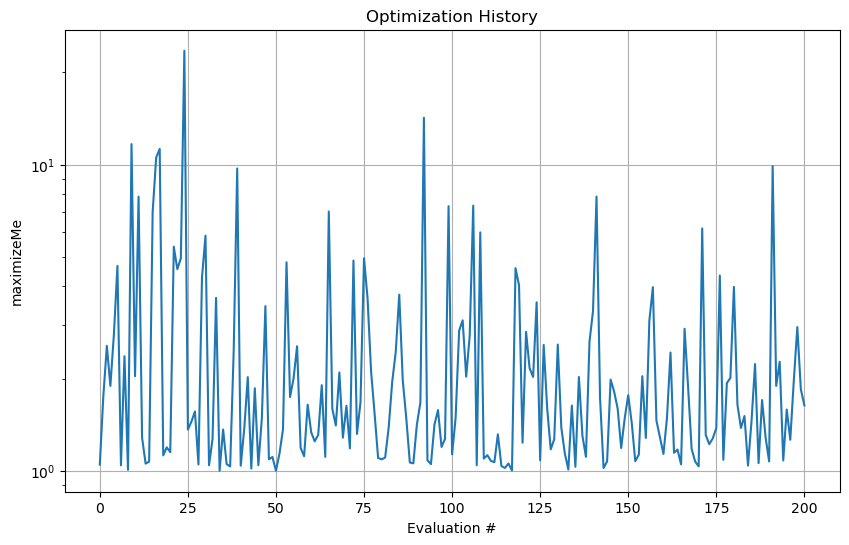

| 201       | 1.635     | -52.41    | 26.59     | 327.5     | -229.2    | -172.5    | 145.0     | 10.59     | -47.25    | -89.07    |
        Q5FFkG      Q4FFkG      Q3FFkG      Q2FFkG      Q1FFkG      Q0FFkG  \
0  -154.427527 -291.879916   85.120917   15.420545 -179.300529  120.294190   
0   -83.452402 -165.466907   51.573344  163.624192  -62.995111   50.220510   
0   -26.321556 -150.983081  154.513120    0.074732 -231.570711   39.741713   
0   -80.855884 -167.605673   37.656309   80.743642  -65.195851  133.415051   
0   -22.168489 -269.922241  432.408738   88.694963  -80.654419  124.461999   
..         ...         ...         ...         ...         ...         ...   
0  -157.771362  -42.130600   35.464574    5.303443 -250.383890   11.598527   
0  -228.694864 -330.167975  231.633245   32.093283  -88.291202   32.253657   
0  -108.676631  -12.638846  407.274086   84.821700 -102.098804   45.231844   
0  -226.104689 -420.178473   30.785965  128.427895 -102.236509   61.747709   
0   -89.

In [20]:
##### from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from IPython.display import display, clear_output

class OptimizationProblem:
    def __init__(self):
        self.history = pd.DataFrame()

    def XTCAVBetaX(self, Q5FFkG, Q4FFkG, Q3FFkG):
        
        setQuadkG("Q5FF", Q5FFkG)
        setQuadkG("Q4FF", Q4FFkG)
        setQuadkG("Q3FF", Q3FFkG)

        XTCAVBetaXVal = tao.ele_twiss("XTCAVF")['beta_a']

        #Collect desired data as a pandas Series
        tmpData = pd.Series({
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "XTCAVBetaX": XTCAVBetaXVal
        #   "finalEmit": finalEmit,
        #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
        #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
        #    "fig": outputFig
        })


        #Split this out to below the export commands so beams can be exported
        #tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        self.history = pd.concat([self.history, tmpData.to_frame().T])

        self.updatePlot()


        
        return XTCAVBetaXVal



        
    def finalFocusOptimization(self, Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG):
        
        setAllFinalFocusQuads(Q5FFkG, Q4FFkG, Q3FFkG, Q2FFkG, Q1FFkG, Q0FFkG, Q0DkG, Q1DkG, Q2DkG)

        #XTCAVBetaXVal = tao.ele_twiss("XTCAVF")['beta_a']
        #DTOTRBetaXVal = tao.ele_twiss("DTOTR")['beta_a']

        
        tao.cmd("set ele XTCAVF VOLTAGE = 10e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        DTOTRSigmaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_sigma_x']
        DTOTRBetaXValTCAVOn = tao.bunch_params("DTOTR")['twiss_beta_x']


        tao.cmd("set ele XTCAVF VOLTAGE = 0e6")
        tao.cmd("set ele XTCAVF PHI0 = 0")
        tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        DTOTRSigmaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_sigma_x']
        DTOTRBetaXValTCAVOff = tao.bunch_params("DTOTR")['twiss_beta_x']
        

        maximizeMe = DTOTRSigmaXValTCAVOn / DTOTRSigmaXValTCAVOff

        
        
        
        
        #bigCost = -1000
        
        #This is just a toy version for now; impose cost for beams that are too big
        #for quadName in quadNameList: 
        #    if tao.ele_twiss(quadName)['beta_a'] > 1e4: maximizeMe += bigCost
        #    if tao.ele_twiss(quadName)['beta_b'] > 1e4: maximizeMe += bigCost

        

        #Collect desired data as a pandas Series
        tmpData = pd.Series({
            "Q5FFkG": Q5FFkG,
            "Q4FFkG": Q4FFkG,
            "Q3FFkG": Q3FFkG,
            "Q2FFkG": Q2FFkG,
            "Q1FFkG": Q1FFkG,
            "Q0FFkG": Q0FFkG,
            "Q0DkG": Q0DkG,
            "Q1DkG": Q1DkG,
            "Q2DkG": Q2DkG,
            "XTCAVBetaX": tao.bunch_params("DTOTR")['twiss_beta_x'],
            "DTOTRSigmaXValTCAVOn": DTOTRSigmaXValTCAVOn,
            "DTOTRSigmaXValTCAVOff": DTOTRSigmaXValTCAVOff,
            "DTOTRBetaXValTCAVOn": DTOTRBetaXValTCAVOn,
            "DTOTRBetaXValTCAVOff": DTOTRBetaXValTCAVOff,
            "maximizeMe": maximizeMe
        #   "finalEmit": finalEmit,
        #   "initialBeam": ParticleGroup(data=tao.bunch_data('L0AFEND')),
        #   "finalBeam": ParticleGroup(data=tao.bunch_data(lastTrackedElement))
        #    "fig": outputFig
        })


        #Split this out to below the export commands so beams can be exported
        tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation
        
        self.history = pd.concat([self.history, tmpData.to_frame().T])

        self.updatePlot()

        
        
        return maximizeMe
        

    def updatePlot(self):
        plotKey = "maximizeMe"
        
        # Clear the previous figure to prevent flickering
        clear_output(wait=True)
        
        # Create a new figure
        plt.figure(figsize=(10, 6))
        #plt.plot(self.history.index, self.history['finalEmit'], '-o', markersize=8)
        plt.plot(np.arange(len(self.history[plotKey])), self.history[plotKey], '-')
        plt.title('Optimization History')
        plt.xlabel('Evaluation #')
        plt.ylabel(plotKey)
        plt.yscale('log')
        plt.grid(True)
        
        # Show plot
        plt.show()

# Instantiate the optimization problem
problem = OptimizationProblem()


#Try https://github.com/bayesian-optimization/BayesianOptimization
#from bayes_opt import BayesianOptimization
import bayes_opt

# Bounded region of parameter space
pbounds = {
    'Q5FFkG': (-256, 0), 
    'Q4FFkG': (-446, 0), 
    'Q3FFkG': (0, 457),
    'Q2FFkG': (0, 167),
    'Q1FFkG': (-257, 0),
    'Q0FFkG': (0, 167),
    'Q0DkG': (-239, 0),
    'Q1DkG': (0, 386),
    'Q2DkG': (-223, 0),
}

optimizer = bayes_opt.BayesianOptimization(
    f=problem.finalFocusOptimization,
    pbounds=pbounds,
    random_state=1,
    allow_duplicate_points=True #2024-04-26 it was whining about this 
)

#Refer to https://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
#and https://github.com/bayesian-optimization/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py
boInitialKappa = 10.
boFinalKappa = 0.1
boNumIter = 200
boKappaDecay = (boFinalKappa / boInitialKappa)**(1/boNumIter)

acquisition_function = bayes_opt.util.UtilityFunction(kind='ucb',
                                   kappa=boInitialKappa,         #Default 2.576
                                   xi=0.0,              #Default 0
                                   kappa_decay=boKappaDecay,       #Default 0
                                   kappa_decay_delay=0  #Default 0                     
                                          )


optimizer.maximize(
    init_points=0, #Initial, random points
    n_iter=boNumIter,
    acquisition_function=acquisition_function
)


#print(res)
print(problem.history) 

In [21]:
problem.history = problem.history.sort_values(by='maximizeMe', ascending=False)
bestConfigData = problem.history.iloc[0]

print( bestConfigData ) 

setAllFinalFocusQuads(
    bestConfigData["Q5FFkG"], 
    bestConfigData["Q4FFkG"], 
    bestConfigData["Q3FFkG"], 
    bestConfigData["Q2FFkG"], 
    bestConfigData["Q1FFkG"], 
    bestConfigData["Q0FFkG"], 
    bestConfigData["Q0DkG"], 
    bestConfigData["Q1DkG"], 
    bestConfigData["Q2DkG"]
)

tao.cmd('set global track_type = beam') #set "track_type = single" to return to single particle
tao.cmd('set global track_type = single') #return to single to prevent accidental long re-evaluation

Q5FFkG                  -244.511588
Q4FFkG                  -252.244119
Q3FFkG                    60.368150
Q2FFkG                     3.837396
Q1FFkG                   -89.796365
Q0FFkG                   135.215928
Q0DkG                   -136.445655
Q1DkG                    320.470439
Q2DkG                    -94.322131
XTCAVBetaX                 1.055091
DTOTRSigmaXValTCAVOn       0.001016
DTOTRSigmaXValTCAVOff      0.000043
DTOTRBetaXValTCAVOn       22.105487
DTOTRBetaXValTCAVOff       1.055091
maximizeMe                23.529703
Name: 0, dtype: float64


[]

In [22]:
problem.history.to_csv('output_data.csv', index=False)


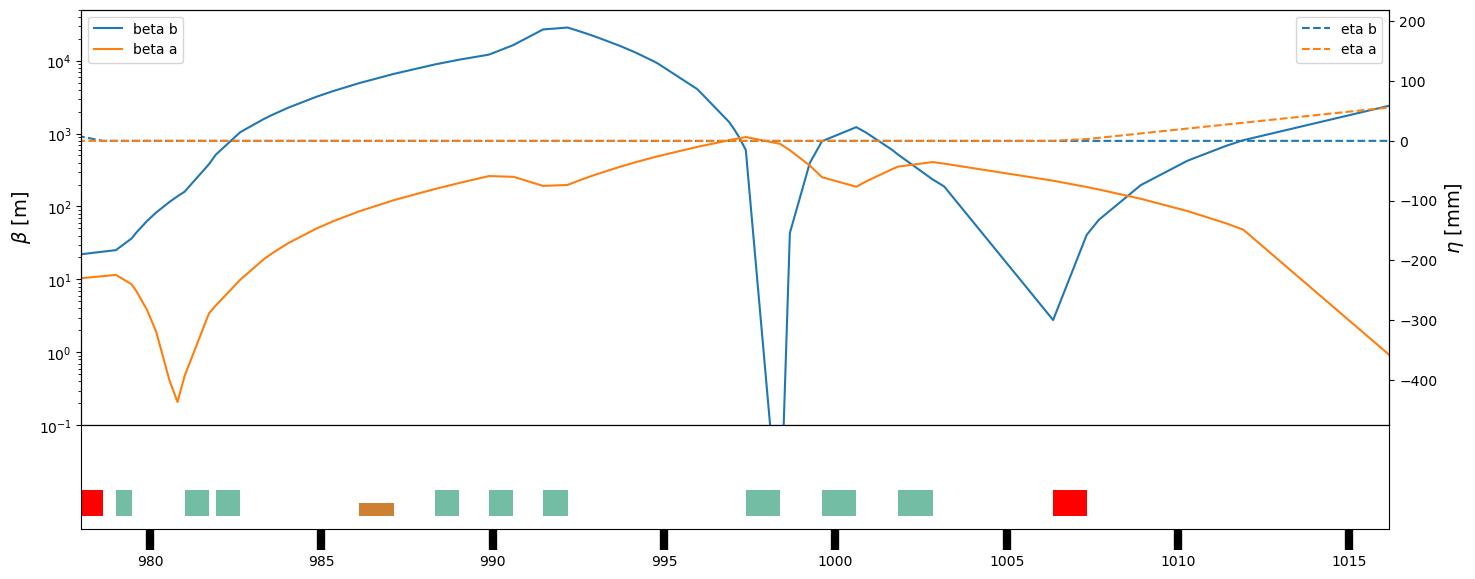

In [26]:
elements=tao.lat_ele_list();


floorplan=pd.read_csv(
    io.StringIO('\n'.join(tao.show('lat -all -floor_coords -tracking_elements')[3:-5])), 
    sep="[\s\n]+",
    engine='python',
    names=['Index','ElementName','ElementType','s','ds','X','Y','Z','Theta','Phi','Psi'])
floorplan.drop(0,inplace=True)


#Get twiss functions
tao.cmd('set global lattice_calc_on = T')
s=np.array([tao.lat_list(x,'ele.s')[0] for x in floorplan.Index])
x=np.array([tao.lat_list(x,'orbit.floor.x')[0] for x in floorplan.Index])
beta_y=np.array([tao.lat_list(x,'ele.a.beta')[0] for x in floorplan.Index])
beta_x=np.array([tao.lat_list(x,'ele.b.beta')[0] for x in floorplan.Index])
etot=np.array([tao.lat_list(x,'ele.e_tot')[0] for x in floorplan.Index])
eta_y=np.array([tao.lat_list(x,'ele.y.eta')[0] for x in floorplan.Index])
eta_x=np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index])


fig = plt.figure(num=1,figsize=[3.375*5,3.375*2])
fig.clf()
ax,ax_fp=format_longitudinal_plot(fig)

ax.semilogy(s,beta_x,label='beta b')
ax.semilogy(s,beta_y,label='beta a')
plt.legend(loc=2)
ax.set_ylim([0.1,50000])
ax_r=ax.twinx()
ax_r.plot(s,eta_x*1e3,'C0--',label='eta b')
ax_r.plot(s,eta_y*1e3,'C1--',label='eta a')
plt.legend(loc=1)
#ax_r.plot(s,beta_y,'k--')
#ax_r.plot(s,np.array([tao.lat_list(x,'ele.x.eta')[0] for x in floorplan.Index]),'--')

ax.set_facecolor('w')
zmin=978
zmax=1016.162829 #DTOTR S = 1016.162829

ax.set_xlabel('Z [m]',fontsize=14)
ax.set_ylabel(r'$\beta$ [m]',fontsize=14)
ax_r.set_ylabel(r'$\eta$ [mm]',fontsize=14)

ax.set_xlim([zmin,zmax])
ax_fp.set_ylim([-1,3])

plt.show()
#fig.savefig('beamline',transparent=False,bbox_inches='tight', dpi=300)

